# 02. Explaining the TEDA RLS Algorithm

The dataset ("_Power.xlsx_") we are examining is the same one used in the notebook titled "#01 - Explaining the TEDA Algorithm". Just as we did there, we are inserting virtual outliers in the curve to test our TEDA RLS algorithm.
This dataset simulates real distribution substation power data, providing measurements of active power every 15 minutes, totaling 96 measurements per day. The dataset covers 10 consecutive days.

## 1. Modules import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from random import randint, sample

#### Importing our modules:

In [2]:
from teda import TEDA
from RLSFilter import RLSFilter

## 2. Data import

### 2.1 Power data:

In [3]:
data = pd.read_excel("PowerWithOutliers.xlsx")
data.head()

,Date,Hour,P,label,P with outliers
0,2010-01-01,00:00:00,770.0,0,770.0
1,2010-01-01,00:15:00,754.0,0,754.0
2,2010-01-01,00:30:00,754.0,0,754.0
3,2010-01-01,00:45:00,724.0,0,724.0
4,2010-01-01,01:00:00,724.0,0,724.0


#### Time stamp:

In [4]:
ts = np.linspace(0, len(data), len(data))

In [5]:
figure = make_subplots(specs=[[{"secondary_y": True}]])

figure.update_layout(
    title="Power Dataset"
)

figure.add_trace(
    go.Scatter(y=data['P'], name='True'),
    secondary_y=False
)
figure.add_trace(
    go.Scatter(y=data['P with outliers'], name='With outliers'),
    secondary_y=False
)

figure.update_xaxes(title='Time (s)')
figure.update_yaxes(title='P (kW)', secondary_y=False)
figure.show()

## 3. Running on Python:

### Defining algorithm instances:

In [6]:
#TEDA
teda = TEDA(threshold=2.5)
correction = True   # Consecutive outlier correction flag
N_outlier_max = 1   # Maximum of outliers corrected by TEDARLS
FLAG = []

#RLS
filter_order = 4                             # Filter_order equivalent to window size
forgetting_factor = 0.999                      # Forgetting factor: It is introduced to give exponentially less weight to older error samples. It is usually chosen between 0.98 and 1.
regularization_factor = 0.1                   # It is usually chose between 0.1 and 1.
w0 = np.zeros(filter_order).tolist()         # Initial weights
X_ant = w0 = np.zeros(filter_order).tolist() # Initial previous input
rls_filter = RLSFilter(n = filter_order, mu = forgetting_factor, delta=regularization_factor, w=w0) #Defining the filter instance

### Defining auxiliary variables:

In [7]:
Ya_py = []          # Vector of auxiliary predicted values
Y_py = []           # Vector of predicted values
DB = []             # Vector of saved values (database)
outlier_count = 0   # Outlier count 
y_pred_py = 0.0     # Initial predicted value

### Running:

In [8]:
for i in data['P with outliers']:
    ## Acquiring the data input
    valor_atual = i

    #Checking if it is an outlier
    flag = teda.run(valor_atual)
    FLAG.append(flag)

    ## First Stage: Correcting outlier
    if (flag == 1):       
        outlier_count = outlier_count + 1
        valor_atual = y_pred_py
    else:
        outlier_count = 0
      
    #Evaluating the flood of outliers
    if(correction == True and outlier_count == N_outlier_max + 1):
        valor_atual = i
    
    #Saving 
    Ya_py.append(y_pred_py)

    # Updating weights
    rls_filter.update(valor_atual, np.array(X_ant))
    input_vector = []
    for j in X_ant[1:]:
        input_vector.append(j)
    input_vector.append(valor_atual)

    #Predicting the next value
    y_pred_py = rls_filter.filter(input_vector)
    Y_py.append(y_pred_py)

    # Second stage
    if (flag == 1):
        valor_atual = y_pred_py

    if(correction == True and outlier_count == N_outlier_max + 1):
        outlier_count = 0
        valor_atual = i
    DB.append(valor_atual)

    #Updating previous values vector
    X_ant = input_vector

data['flag_py'] = FLAG
#data['x_antp'] = data['x_ant']
data['save_py'] = DB
data['ya_pred_py'] = Ya_py
data['y_pred_py'] = Y_py

## 4. Visualization:

### 4.1 TEDA

In [9]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

In [10]:
numberOfOutliersPython = data['flag_py'].sum()
numberOfOutliersPython

40

In [11]:
outliersIndexPython = find_indices(data['flag_py'], 1)
#outliersIndexPython

### TEDA Chart

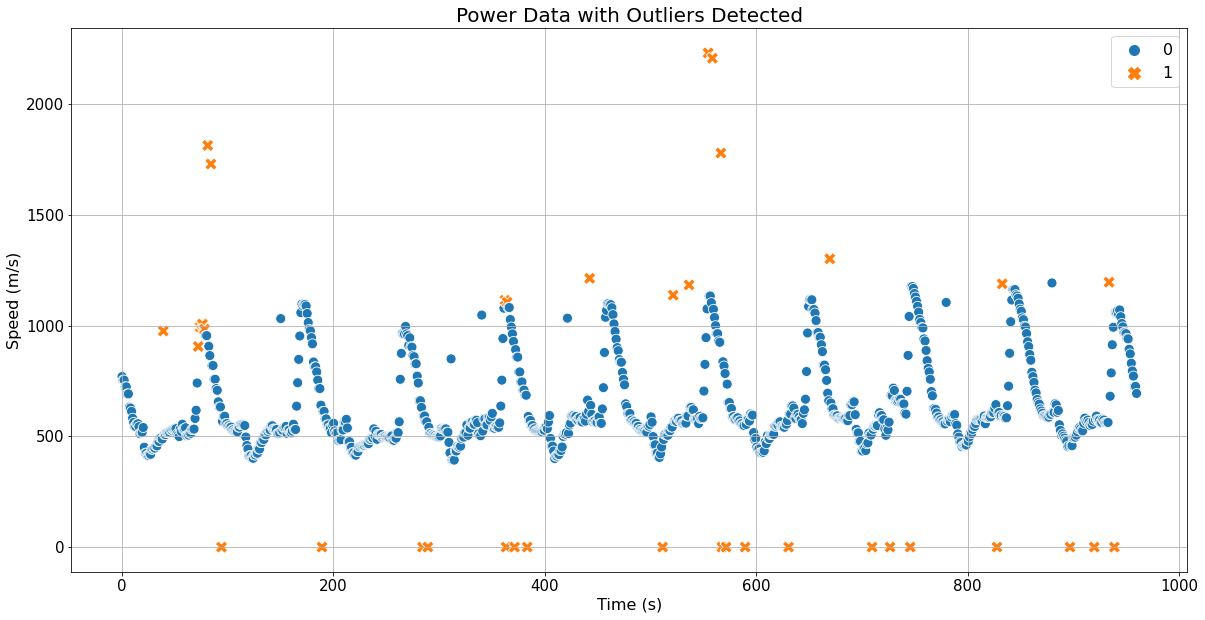

In [12]:
plt.figure(figsize=(20,10))
plt.grid()
plt.title("Power Data with Outliers Detected", fontsize=20)
sns.scatterplot(x=ts, y=data['P with outliers'], hue=data['flag_py'], style=data['flag_py'], size=data['flag_py'], sizes=(150, 100))
plt.legend(fontsize=16)
plt.ylabel("Speed (m/s)", fontsize=16)
plt.xlabel("Time (s)", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 4.2 RLS

In [13]:
figure = make_subplots(specs=[[{"secondary_y": True}]])

figure.update_layout(
    title="Speed Dataset"
)

#figure.add_trace(
#    go.Scatter(y=data['P'], name='True'),
#    secondary_y=False
#)

figure.add_trace(
    go.Scatter(y=data['P with outliers'], name='With outliers'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(y=data['ya_pred_py'], name='Auxiliary'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(y=data['y_pred_py'], name='Predicted'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(y=data['save_py'], name='Saved'),
    secondary_y=False
)


figure.update_xaxes(title='Time (s)')
figure.update_yaxes(title='Speed (m/s)', secondary_y=False)
figure.show()

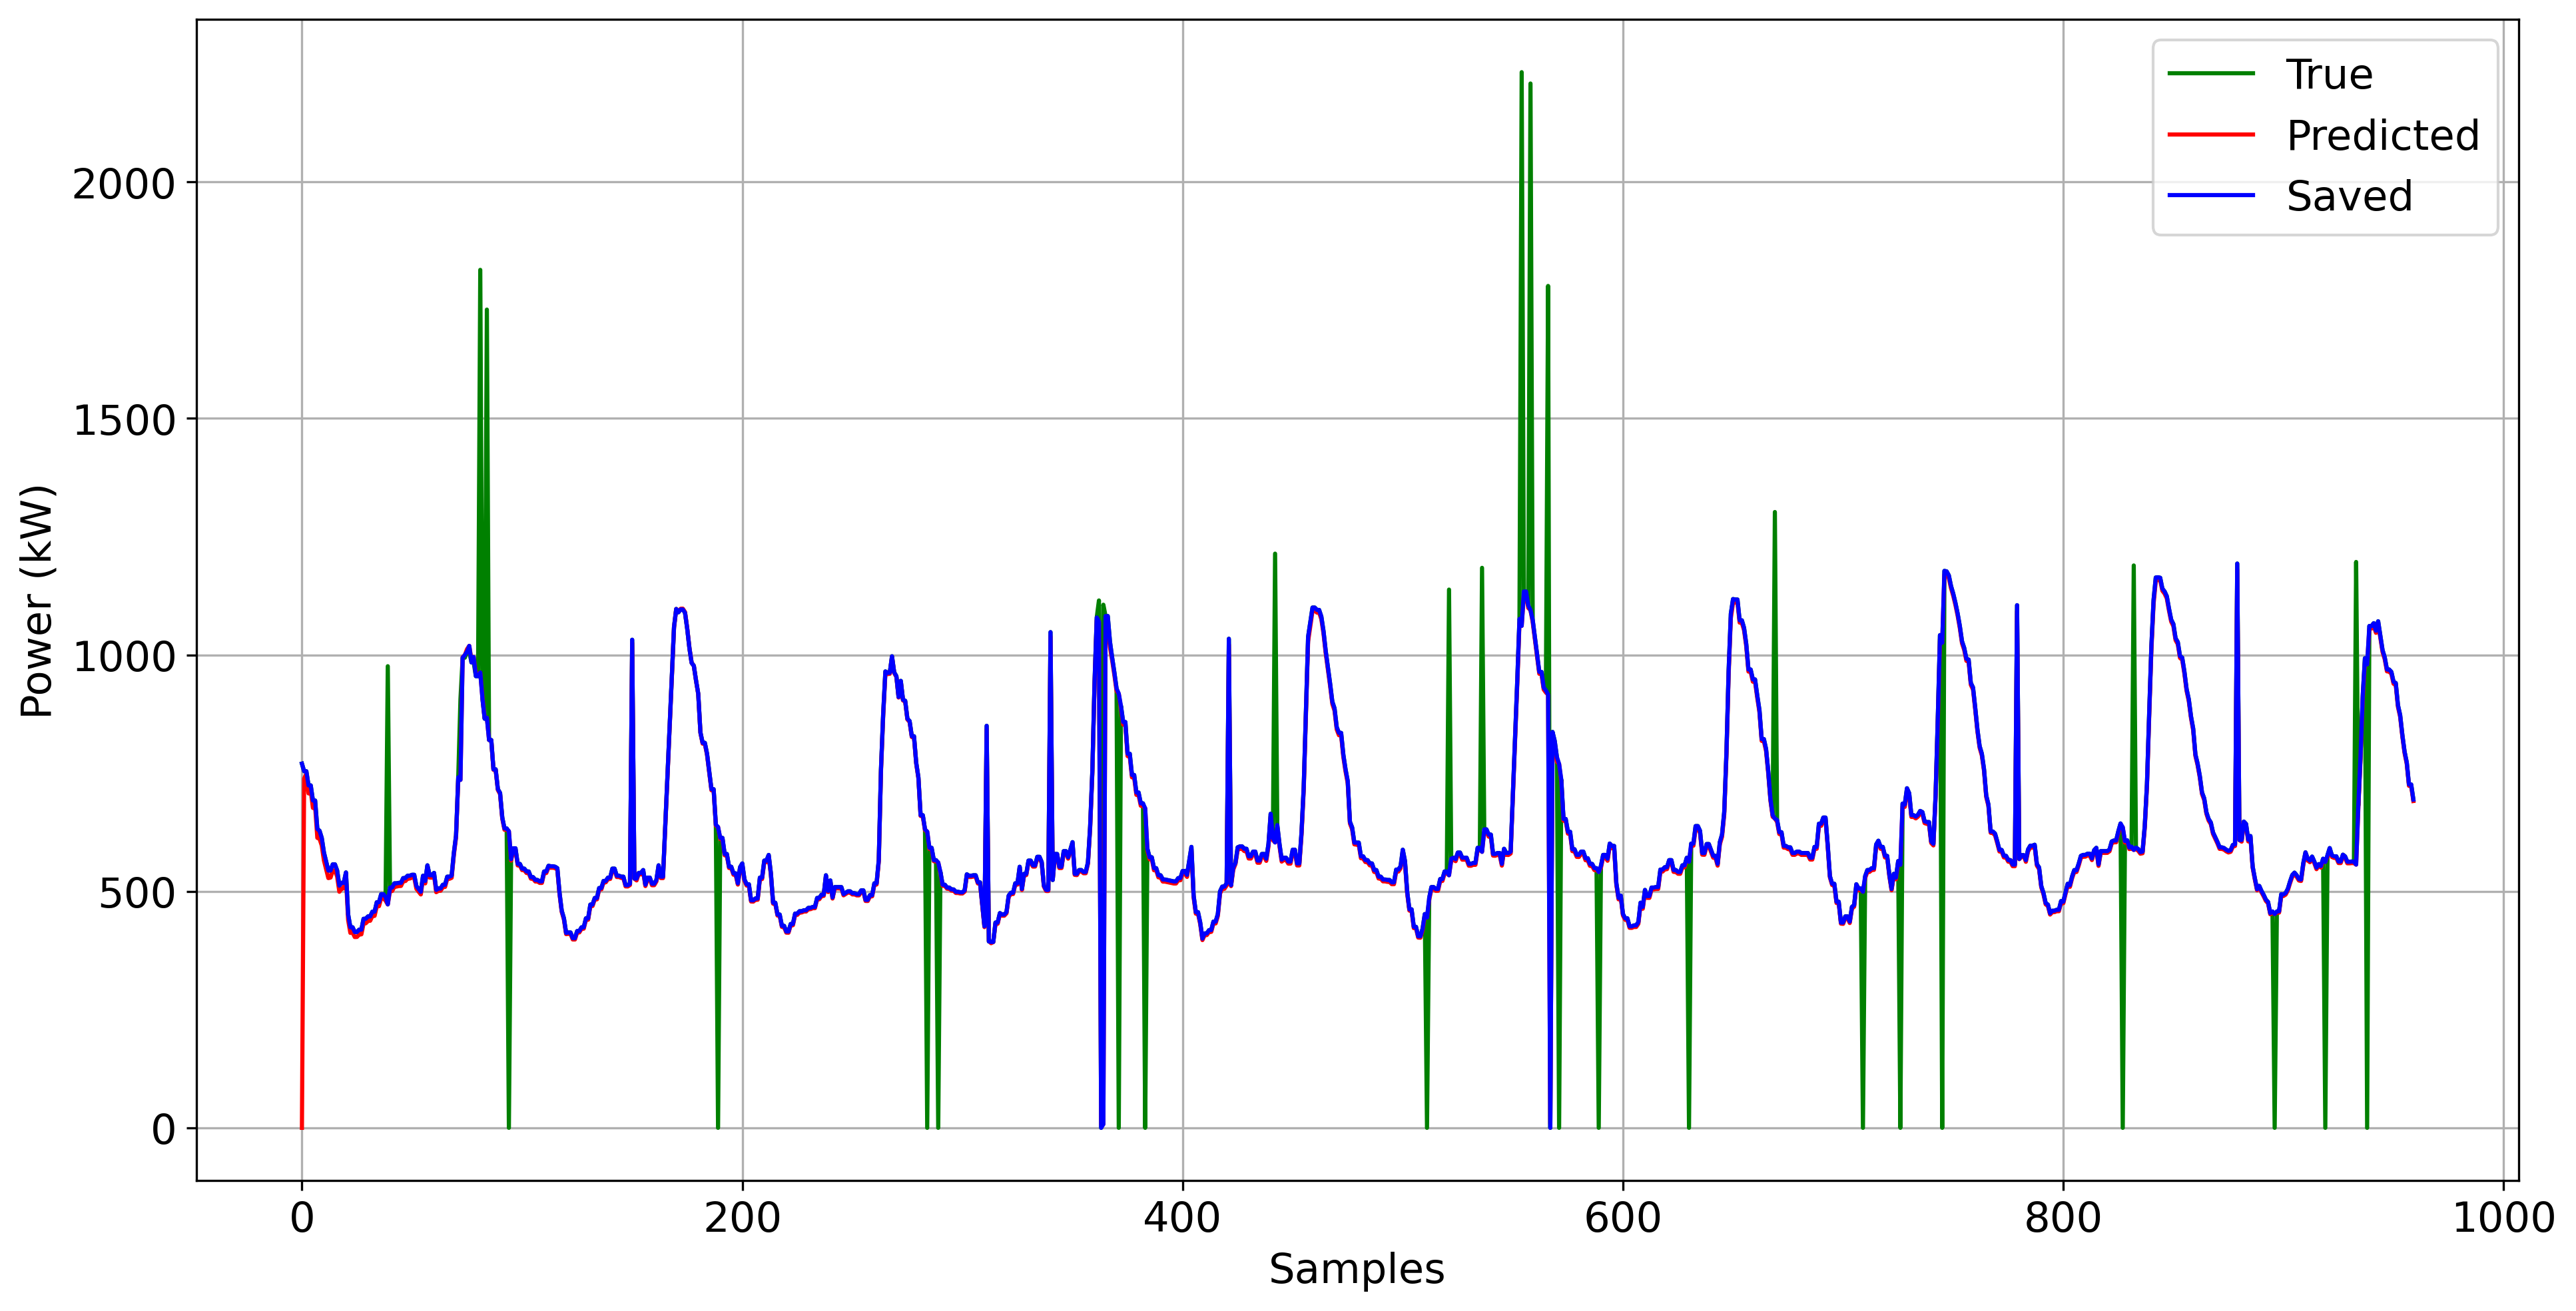

In [14]:
plt.figure(figsize=(15,7.7), dpi=300)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.xlabel("Samples", fontsize=15)
plt.ylabel("Power (kW)", fontsize=15)
plt.plot(data['P with outliers'], 'g', label='True')
plt.plot(data['y_pred_py'], 'r', label='Predicted')
plt.plot(data['save_py'], 'b', label='Saved')
plt.legend(fontsize=15)

plt.savefig("C:/Users/Samsung/Desktop/Pedro/UFRN/Portfolio/Publicados/TEDA RLS/Python/figures/Power/results_Power_curves.png", dpi=600, bbox_inches='tight')

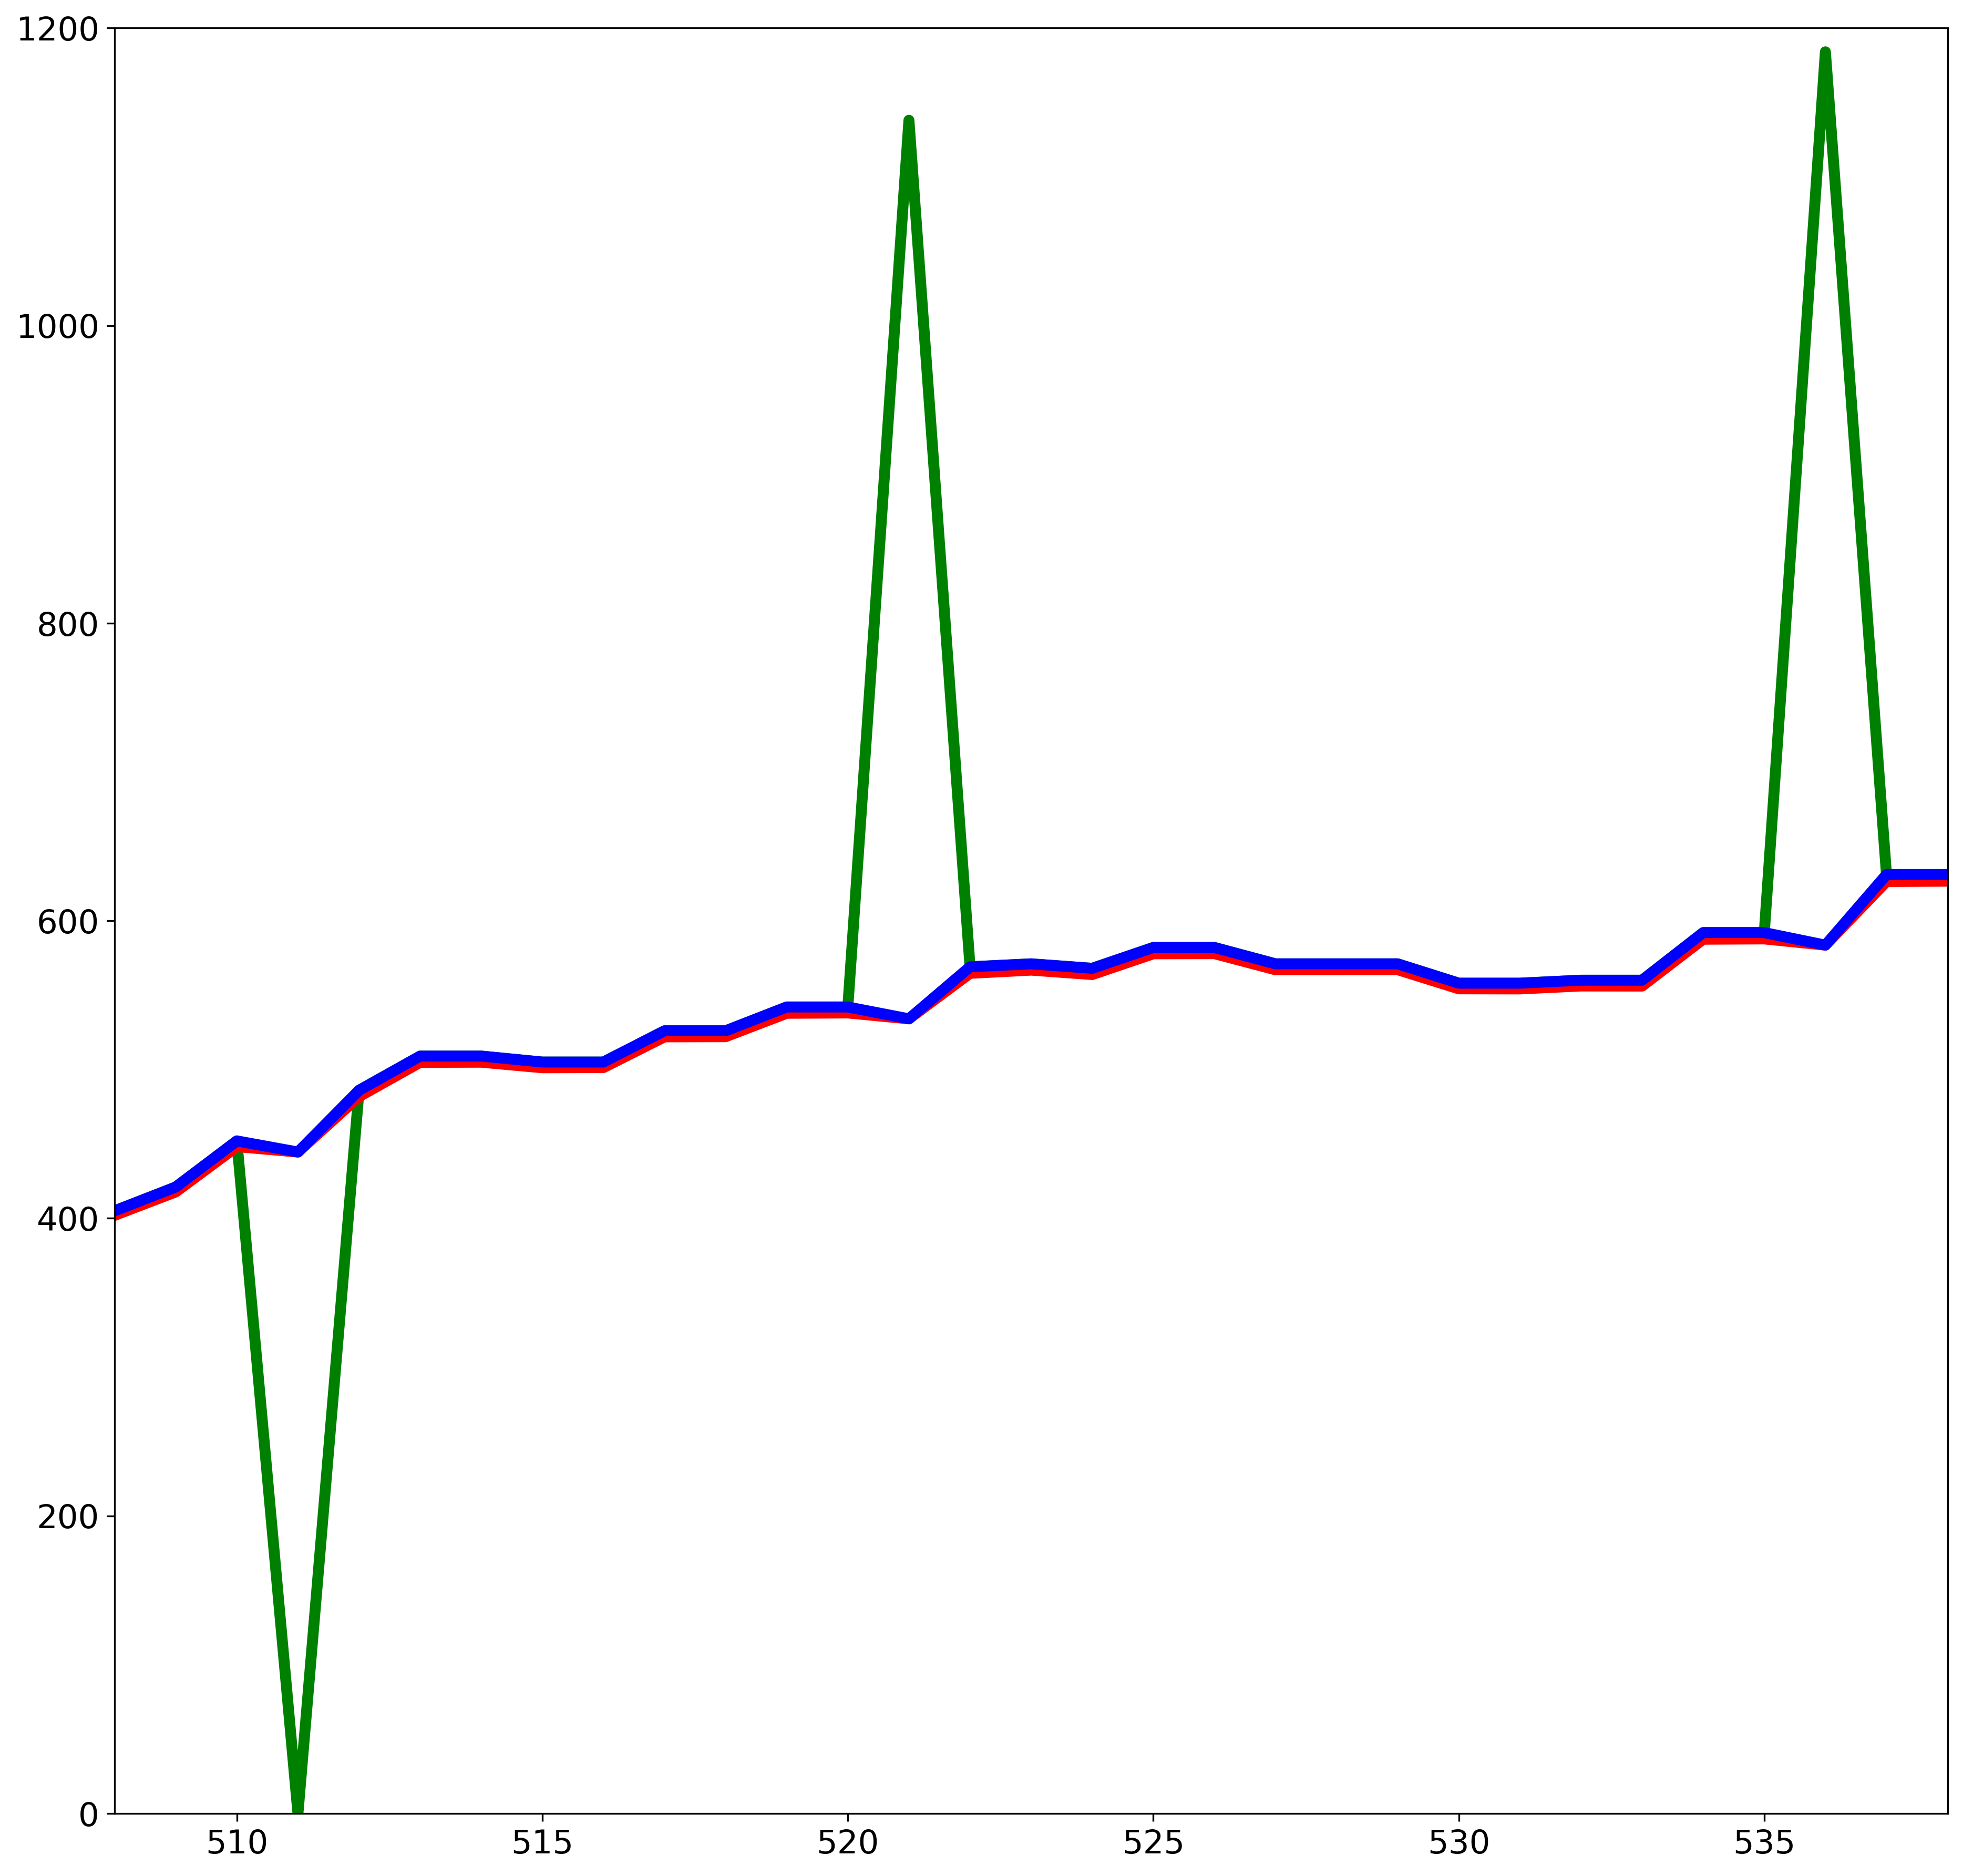

In [15]:
plt.figure(figsize=(15,15), dpi=300)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((508, 538))
plt.ylim((0, 1200))
plt.plot(data['P with outliers'], 'g', linewidth=5)
plt.plot(data['y_pred_py'], 'r', linewidth=5)
plt.plot(data['save_py'], 'b', linewidth=5)


# 5. Metrics

In this section, we will present the metrics for the TEDA classification algorithm, including the **classification report** and **confusion_matrix**, as well as for the RLS forecasting algorithm, which includes the **Mean Squared Error** (MSE) and **Mean Absolute Error** (MAE).

### 5.1 TEDA Evaluation

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score

#### 5.1.1 Confusion matrix:

$$
CM = \begin{bmatrix}
TN & FP\\ 
FN & TP
\end{bmatrix}
$$

In [17]:
print(confusion_matrix(data['label'], data['flag_py']))

[[914   9]
 [  6  31]]


#### 5.1.2 *f1* score:

In [18]:
print(f1_score(data['label'], data['flag_py']))

0.8051948051948051


#### 5.1.3 Accuracy

In [19]:
print(accuracy_score(data['label'], data['flag_py']))

0.984375


#### 5.1.4 Recall:

In [20]:
print(recall_score(data['label'], data['flag_py']))

0.8378378378378378


#### 5.1.5 Classification report:

In [21]:
print(classification_report(data['label'], data['flag_py']))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       923
           1       0.78      0.84      0.81        37

    accuracy                           0.98       960
   macro avg       0.88      0.91      0.90       960
weighted avg       0.99      0.98      0.98       960



### 5.2 RLS Evaluation
The MSE and MAE metrics will be applied between the current values and the values corrected/saved by the algorithm, as well as between the current values and the values predicted by the RLS algorithm.

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [23]:
start = 0

#### 5.2.1 RMSE

##### Comparing to Saved Values

In [24]:
rmse_saved_py = mean_squared_error(data['P with outliers'].iloc[start:], data['save_py'].iloc[start:], squared=False)
rmse_saved_py

130.31322802761701

##### Comparing to Predicted Values

In [25]:
rmse_pred_py = mean_squared_error(data['P with outliers'].iloc[start:], data['y_pred_py'].iloc[start:], squared=False)
rmse_pred_py

132.74120726027172

#### 5.2.2 MAE

##### Comparing to Saved Values

In [26]:
mae_saved_py = mean_absolute_error(data['P with outliers'].iloc[start:], data['save_py'].iloc[start:])
mae_saved_py

22.37909969296298

##### Comparing to Predicted Values

In [27]:
mae_pred_py = mean_absolute_error(data['P with outliers'].iloc[start:], data['y_pred_py'].iloc[start:])
mae_pred_py

27.115798301292852

# 6. WandB

## 6.1 WandB importing

In [28]:
#!pip install wandb

In [29]:
import wandb
import logging

In [30]:
!wandb login 

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Samsung/.netrc


#### Initialize a new W&B run to track this job

In [31]:
run = wandb.init(project="TEDARegressor", job_type="dataset-creation")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pedrohmeira (embarca-ai). Use `wandb login --relogin` to force relogin


In [32]:
# Create a new artifact, which is a sample dataset
dataset = wandb.Artifact('PowerWithOutliers.xlsx', type='dataset')
# Add files to the artifact, in this case a simple text file
dataset.add_file('PowerWithOutliers.xlsx')
# Log the artifact to save it as an output of this run
run.log_artifact(dataset)

### Configure logging:

In [33]:
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

### Defining dictionaries:

1. Metric dictionary:

In [34]:
metric_dict = {
    'name': 'rmse_pred_py',
    'goal': 'minimize'   
    }

2. Parameters dictionary:

In [35]:
parameters_dict = {
    #TEDA RLS
    'Threshold': {
          'values': [2, 2.2, 2.35, 2.5]
        },
    'FlagCorrection': {
          'values': [True, False]
        },
    'N_outlier_max': {
          'values': [1,2,3]
        },   
    'FilterOrder': {
      'values': [2,3,4]
    },
    'Forgetting': {
          'values': [0.5, 0.98, 0.99, 0.999, 1]
        },    
    'Regularization': {
          'values': [0.1, 1, 10]         
        },
}

### Defining Sweep:

In [36]:
seed = 41
sweep_config = {
    "method": "grid", ## Bayesian search => atraves de modelo probabilístico
    "metric": metric_dict,
    "parameters": parameters_dict,

}
sweep_id = wandb.sweep(sweep_config, project="TEDARegressor")

Create sweep with ID: d4batgf1
Sweep URL: https://wandb.ai/embarca-ai/TEDARegressor/sweeps/d4batgf1


### Training:

In [37]:
def train():
    with wandb.init() as run:
        #TEDA
        teda = TEDA(threshold=wandb.config.Threshold)
        FLAG = []

        #RLS
        N_order = wandb.config.FilterOrder  # Filter_order equivalent to window size
        w0 = np.zeros(N_order).tolist()     # Initial weights
        X_ant = np.zeros(N_order).tolist()  # Initial previous input
        rls_filter = RLSFilter(n = N_order, mu = wandb.config.Forgetting, delta=wandb.config.Regularization, w=w0) #Defining the filter instance
        N_outlier_max = wandb.config.N_outlier_max  # Maximum of outliers corrected by TEDARLS
        correction = wandb.config.FlagCorrection    # Consecutive outlier correction flag

        Ya_py = []          # Vector of auxiliary predicted values
        Y_py = []           # Vector of predicted values
        DB = []             # Vector of saved values (database)
        outlier_count = 0   # Outlier count 
        y_pred_py = 0.0     #Initial predicted value
        

        for i in data['P with outliers']:
            ## Acquiring the data input
            valor_atual = i

            #Checking if it is an outlier
            flag = teda.run(valor_atual)
            FLAG.append(flag)

            ## First Stage: Correcting outlier
            if (flag == 1):       
                outlier_count = outlier_count + 1
                valor_atual = y_pred_py
            else:
                outlier_count = 0
            
            #Evaluating the flood of outliers
            if(correction == True and outlier_count == N_outlier_max + 1):
                valor_atual = i
            
            #Saving 
            Ya_py.append(y_pred_py)

            # Updating weights
            rls_filter.update(valor_atual, np.array(X_ant))
            input_vector = []
            for j in X_ant[1:]:
                input_vector.append(j)
            input_vector.append(valor_atual)

            #Predicting the next value
            y_pred_py = rls_filter.filter(input_vector)
            Y_py.append(y_pred_py)

            # Second stage
            if (flag == 1):
                valor_atual = y_pred_py

            if(correction == True and outlier_count == N_outlier_max + 1):
                outlier_count = 0
                valor_atual = i
            DB.append(valor_atual)

            #Updating previous values vector
            X_ant = input_vector

        
        #TEDA Metrics
        f1 = f1_score(data['label'], FLAG)
        accuracy = accuracy_score(data['label'], FLAG)
        recall = recall_score(data['label'], FLAG)

        # Logging
        run.summary['f1_score'] = f1
        wandb.log({"f1_score": f1})
        run.summary['accuracy'] = accuracy
        wandb.log({"accuracy": accuracy})
        run.summary['recall'] = recall
        wandb.log({"recall": recall})
        
        #RLS Metrics
        #RMSE
        rmse_saved_py = mean_squared_error(data['P with outliers'], DB, squared=False)
        rmse_pred_py = mean_squared_error(data['P with outliers'], Y_py, squared=False)
        #MAE
        mae_saved_py = mean_absolute_error(data['P with outliers'], DB)
        mae_pred_py = mean_absolute_error(data['P with outliers'], Y_py)

        # Logging
        # RMSE
        run.summary['rmse_saved'] = rmse_saved_py
        wandb.log({"rmse_saved": rmse_saved_py})
        run.summary['rmse_pred'] = rmse_pred_py
        wandb.log({"rmse_pred": rmse_pred_py})
        # MAE
        run.summary['mae_saved'] = mae_saved_py
        wandb.log({"mae_saved": mae_saved_py})
        run.summary['mae_pred'] = mae_pred_py
        wandb.log({"mae_pred": mae_pred_py})      
 

In [ ]:
wandb.agent(sweep_id, train)

# 7. Sweep Analysis

## 7.1 Visualization

Here, we can visualize the Sweep Results 👀. We have use the **Parallel Coordinates Plot 🔀** to map hyperparameter values to model metrics.
We've used to see the combinations of hyperparameters that led to the **best model performance 📊**:


#### Sweep Power Data

![Sweep Power Data](figures/Power/Power_sweep.png)

The WandB platform allows the download of a maximum of 1000 models, and since a total of 1152 configurations were run, we need to split them according to the threshold, resulting in 4 datasets of 288 models each.

In [3]:
df_sweep_teda_2 = pd.read_csv("sweeps/power_sweep_teda_2.csv")
df_sweep_teda_2_2 = pd.read_csv("sweeps/power_sweep_teda_2_2.csv")
df_sweep_teda_2_35 = pd.read_csv("sweeps/power_sweep_teda_2_35.csv")
df_sweep_teda_2_5 = pd.read_csv("sweeps/power_sweep_teda_2_5.csv")

After downloading each dataset, we will concatenate them into a single DataFrame.

In [4]:
df_power_sweep = pd.concat([df_sweep_teda_2, df_sweep_teda_2_2, df_sweep_teda_2_35, df_sweep_teda_2_5])

## 7.2 TEDA Metrics

### To analyze TEDA, we must evaluate the classification metrics (accuracy, recall, and f1 score) for each sensitivity threshold of the algorithm.

In [5]:
threshold_label = ["2", "2.2", "2.35", "2.5"]
results_acc = [df_sweep_teda_2['accuracy'].iloc[0], df_sweep_teda_2_2['accuracy'].iloc[0], df_sweep_teda_2_35['accuracy'].iloc[0], df_sweep_teda_2_5['accuracy'].iloc[0]]
results_recall = [df_sweep_teda_2['recall'].iloc[0], df_sweep_teda_2_2['recall'].iloc[0], df_sweep_teda_2_35['recall'].iloc[0], df_sweep_teda_2_5['recall'].iloc[0]]
results_f1 = [df_sweep_teda_2['f1_score'].iloc[0], df_sweep_teda_2_2['f1_score'].iloc[0], df_sweep_teda_2_35['f1_score'].iloc[0], df_sweep_teda_2_5['recall'].iloc[0]]

In [6]:
df = pd.DataFrame(data={"Threshold": threshold_label, "Accuracy": results_acc, "Recall": results_recall, "f1 score": results_f1})
df.head()

,Threshold,Accuracy,Recall,f1 score
0,2,0.940625,0.972973,0.558140
1,2.2,0.951042,0.891892,0.584071
2,2.35,0.966667,0.864865,0.666667
3,2.5,0.984375,0.837838,0.837838


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


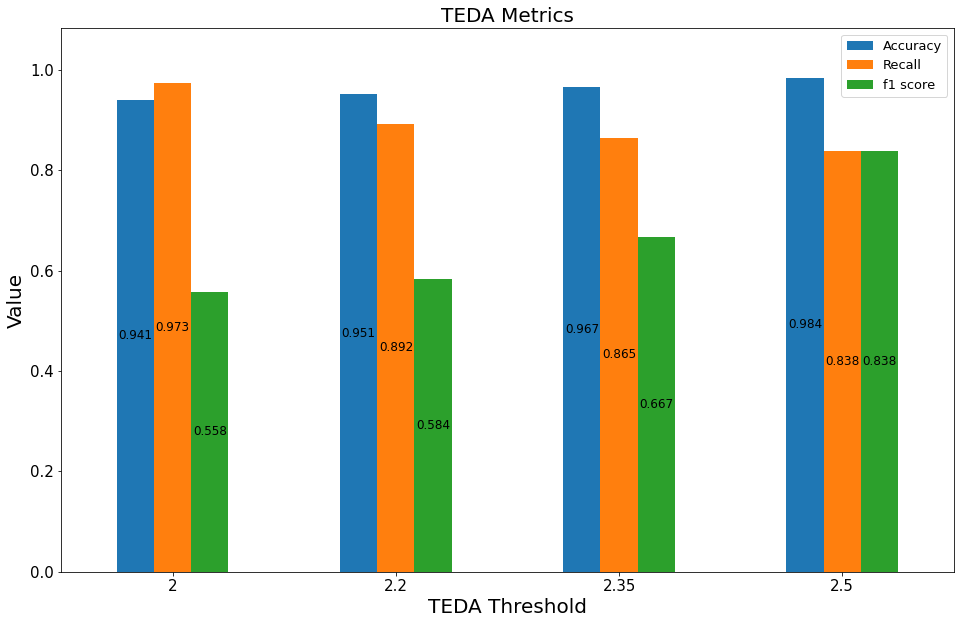

In [7]:
# plot bars or kind='barh' for horizontal bars; adjust figsize accordingly
ax = df.plot(kind='bar', rot=0, xlabel='Threshold', ylabel='Recall', figsize=(16, 10))

X_axis = np.arange(len(threshold_label))

# add some labels
for c in ax.containers:
    # set the bar label
    ax.bar_label(c, fmt='%.3f', label_type='center',fontsize=12)
    
# add a little space at the top of the plot for the annotation
ax.margins(y=0.1)

plt.xticks(X_axis, threshold_label) 

# move the legend out of the plot
ax.legend(fontsize=13)

plt.title("TEDA Metrics", fontsize=20)
plt.xlabel("TEDA Threshold", fontsize=20)
plt.ylabel("Value", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.show()

#plt.savefig('', format='png', bbox_inches='tight')

## 7.3 RLS

### 7.3.1 Lower RMSE of the predicted values ($RMSE_{pred}$):

In [8]:
df_power_sweep[df_power_sweep['rmse_pred']==df_power_sweep['rmse_pred'].min()]

,Name,Threshold,FlagCorrection,N_outlier_max,FilterOrder,Forgetting,Regularization,accuracy,f1_score,recall,rmse_pred,rmse_saved,mae_pred,mae_saved
50,still-sweep-874,2.2,True,1,4,1.0,10.0,0.951042,0.584071,0.891892,126.952931,124.38814,27.544862,22.267151


### 7.3.2 Lower RMSE of the saved values ($RMSE_{saved}$):

In [9]:
df_power_sweep[df_power_sweep['rmse_saved']==df_power_sweep['rmse_saved'].min()]

,Name,Threshold,FlagCorrection,N_outlier_max,FilterOrder,Forgetting,Regularization,accuracy,f1_score,recall,rmse_pred,rmse_saved,mae_pred,mae_saved
50,still-sweep-874,2.2,True,1,4,1.0,10.0,0.951042,0.584071,0.891892,126.952931,124.38814,27.544862,22.267151


### 7.3.3 Lower MAE of the predicted values ($MAE_{pred}$):

In [10]:
df_power_sweep[df_power_sweep['mae_pred']==df_power_sweep['mae_pred'].min()]

,Name,Threshold,FlagCorrection,N_outlier_max,FilterOrder,Forgetting,Regularization,accuracy,f1_score,recall,rmse_pred,rmse_saved,mae_pred,mae_saved
18,wise-sweep-832,2.5,True,1,4,0.999,0.1,0.984375,0.805195,0.837838,132.741207,130.313228,27.115798,22.3791


### 7.3.4 Lower MAE of the saved values ($MAE_{saved}$):

In [11]:
df_power_sweep[df_power_sweep['mae_saved']==df_power_sweep['mae_saved'].min()]

,Name,Threshold,FlagCorrection,N_outlier_max,FilterOrder,Forgetting,Regularization,accuracy,f1_score,recall,rmse_pred,rmse_saved,mae_pred,mae_saved
36,peach-sweep-48,2.5,True,1,2,0.98,10.0,0.984375,0.805195,0.837838,131.782761,129.097412,29.416324,22.234766


# 8. References

 [[1]](https://www.mdpi.com/1424-8220/22/10/3838) **Andrade, P.**; Silva, I.; Silva, M.; Flores, T.; Cassiano, J.; Costa, D.G. *A TinyML Soft-Sensor Approach for Low-Cost Detection and Monitoring of Vehicular Emissions*. SENSORS 2022, 22, 3838.  ![GitHub](https://img.shields.io/badge/DOI-10.3390%2Fs22103838-green)


[[2]](https://dl.acm.org/journal/tecs) **Andrade, P.**; Silva, I.; Silva, M.; Flores, T.; Costa, D.G. Soares, E.; _Online Processing of Vehicular Data on the Edge Through an Unsupervised TinyML Regression Technique_. ACM TECS 2023. ![GitHub](https://img.shields.io/badge/DOI-10.1145%2Fs3591356-green)